In [51]:
from iohblade.loggers import ExperimentLogger
from iohblade import plot_convergence, plot_experiment_CEG, plot_boxplot_fitness_hue
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json


def plot_landscape(row, bounds=(-5, 5), res=200):
    """
    row  : one row of the dataframe (df.loc[idx] or df.iloc[idx])
    bounds: (low, high) tuple applied to both axes
    res   : grid resolution per axis
    """
    # Re-create the callable from the code string
    ns = {}
    exec(row["code"], ns)                      # defines class with same name as row["name"]
    f   = getattr(ns[row["name"]](dim=2), "f")      # instantiate & grab its .f method

    # Grid
    x = np.linspace(bounds[0], bounds[1], res)
    y = np.linspace(bounds[0], bounds[1], res)
    X, Y = np.meshgrid(x, y)
    pts   = np.stack([X.ravel(), Y.ravel()], axis=1)
    Z     = np.apply_along_axis(f, 1, pts).reshape(X.shape)   # robust fallback

    # Plot
    fig, ax = plt.subplots(figsize=(6, 5))
    cs = ax.contourf(X, Y, Z, levels=50, cmap="viridis")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title(f"Landscape of {row['name']}")
    plt.colorbar(cs, ax=ax, label="f(x)")
    plt.tight_layout()
    return fig, ax

logger = ExperimentLogger('../results/ELA_experiment', True)
# logger.add_read_dir('../results/kerneltuner-o4')
# logger.add_read_dir('../results/kerneltuner-o4-no-info')

In [52]:
methods, problems = logger.get_methods_problems()
print(methods)
print(problems)

['LLaMEA-gpt-5-nano', 'LLaMEA-qwen2.5-coder_14b', 'LLaMEA-gemini-2.0-flash']
['multimodal_structure', 'basins_separable']


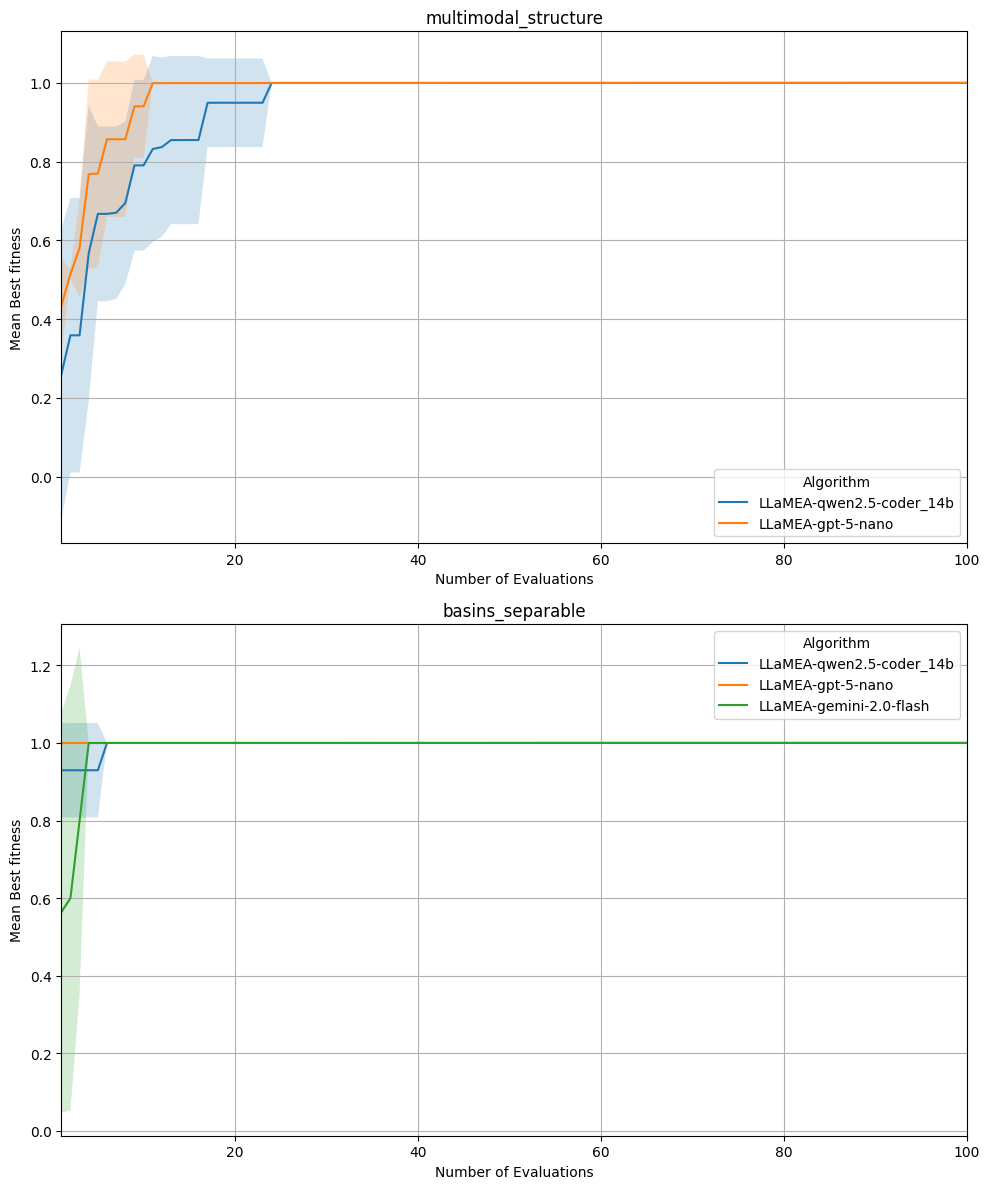

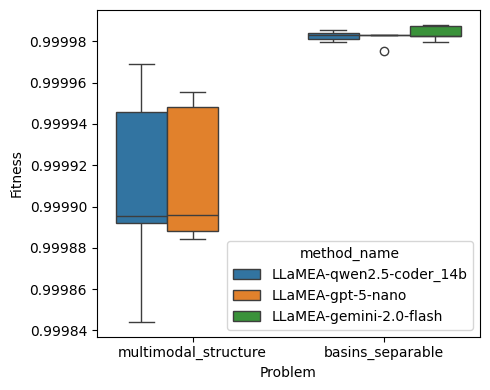

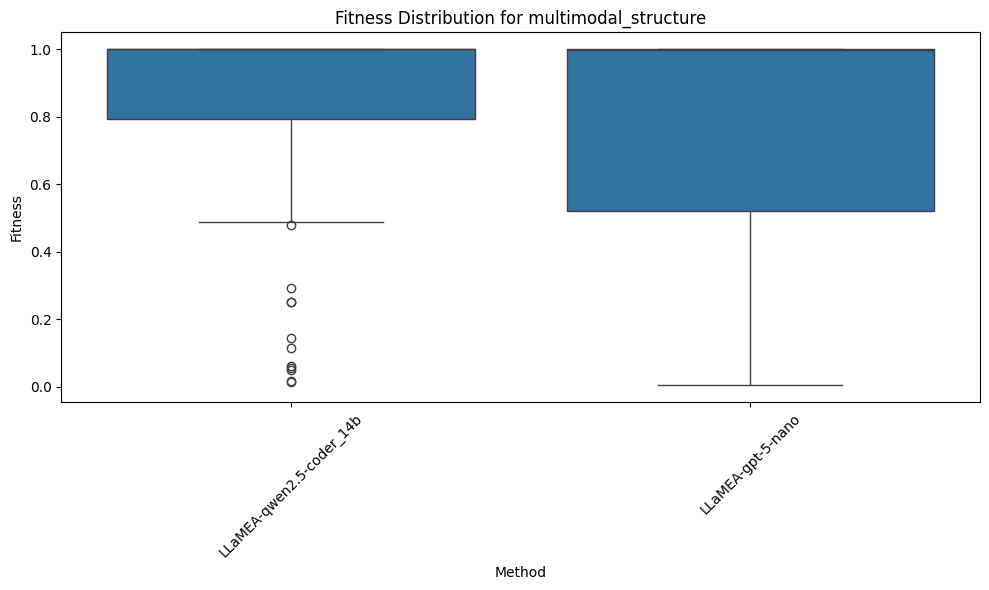

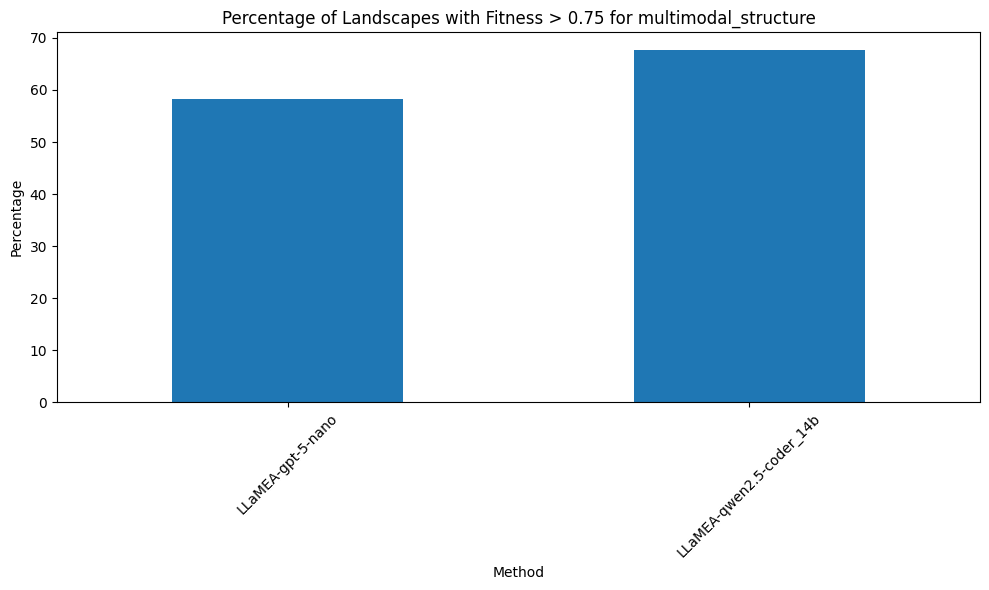

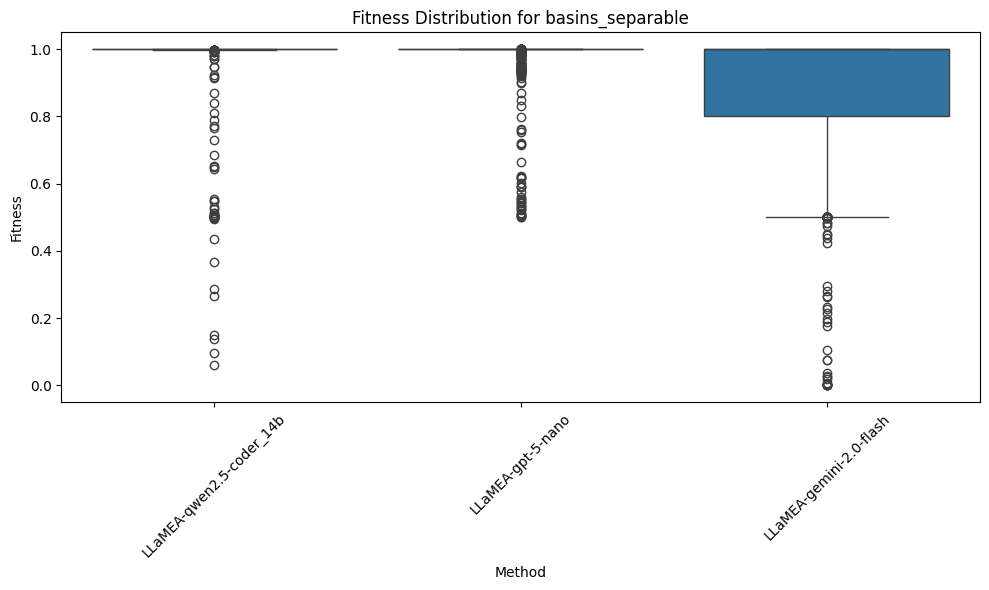

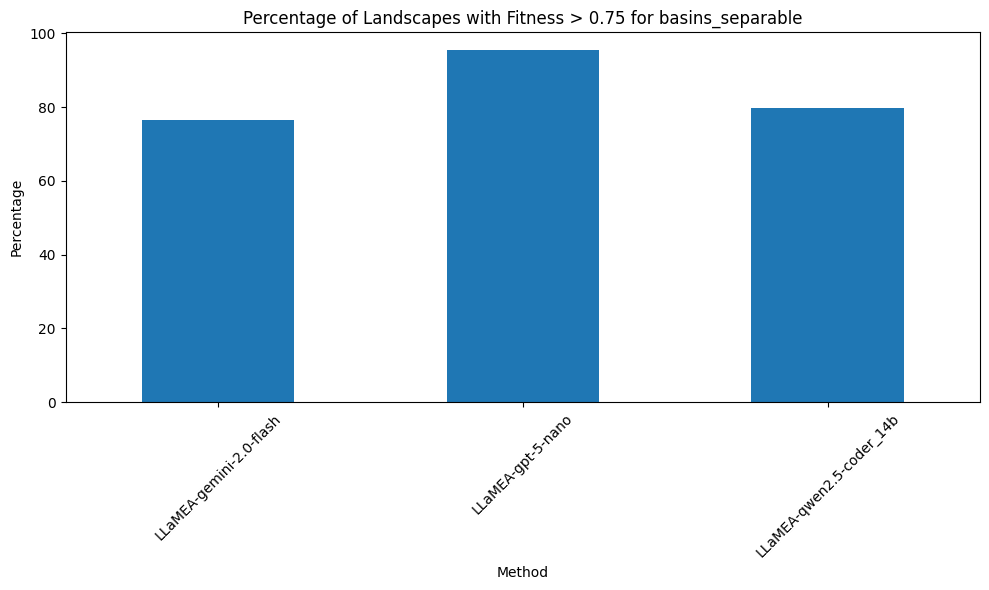

In [53]:

plot_convergence(logger, metric="fitness", save=False, budget=100)
plot_boxplot_fitness_hue(logger)


methods, problems = logger.get_methods_problems()
for problem in problems:
    data = logger.get_problem_data(problem_name=problem)
    if problem == "basins_separable":
        # The fitness values are wrong for this problem, we can fix them though, fitness should be score_basins_scaled + (score_separable_scaled + 99) / 100
        # We should check for each method and seed if the score_separable_scaled is negative, if so we can use the formula above
        for method in methods:
            if method not in data['method_name'].values:
                continue
            seeds = data[data['method_name'] == method]['seed'].unique()
            for seed in seeds:
                subset_idx = data.index[(data['method_name'] == method) & (data['seed'] == seed)]
                meta_df = pd.json_normalize(data.loc[subset_idx, 'metadata'])
                if len(meta_df[meta_df['score_separable_scaled'] < 0]) > 0:
                    m = (data['method_name'] == method) & (data['seed'] == seed)

                    sep = data.loc[m, 'metadata'].apply(lambda d: d.get('score_separable_scaled', float('-inf')))
                    bas = data.loc[m, 'metadata'].apply(lambda d: d.get('score_basins_scaled', float('-inf')))

                    calc = (bas + (sep + 99) / 100) / 2

                    data.loc[m, 'fitness'] = calc.to_numpy()


    # create a boxplot to show fitness distribution per method
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.boxplot(data=data, x='method_name', y='fitness', ax=ax)
    ax.set_title(f"Fitness Distribution for {problem}")
    ax.set_xlabel("Method")
    ax.set_ylabel("Fitness")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # now count the number of landscapes with a fitness above 0.75 per method and show this as a bar plot
    counts = data[data['fitness'] > 0.75].groupby('method_name').size() / data.groupby('method_name').size() * 100  # percentage
    fig, ax = plt.subplots(figsize=(10, 6))
    counts.plot(kind='bar', ax=ax)
    ax.set_title(f"Percentage of Landscapes with Fitness > 0.75 for {problem}")
    ax.set_xlabel("Method")
    ax.set_ylabel("Percentage")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()